# Test modelos : Predicción a futuro

In [1]:
#pre-requisites
!pip install skforecast
!pip install dask[dataframe]
!pip install lightgbm
!pip install matplotlib
!pip install xgboost
!pip install --upgrade pandas ipython

  Using cached pandas-2.1.4-cp39-cp39-win_amd64.whl (10.8 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skforecast 0.11.0 requires pandas<2.2,>=1.2, but you have pandas 2.2.2 which is incompatible.


In [17]:
import importlib
import joblib
import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# forecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# models
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

warnings.filterwarnings('once')


In [18]:
data = pd.read_csv('../FitBit API Database/test_train_data_api_merged.csv')
print("Archivo: test_train_data_api_merged.csv")
print(data)

Archivo: test_train_data_api_merged.csv
            Id                 Time  Calories  Distance  Steps  HeartRate
0       BSGSML  2024-02-15 18:13:00   1.30970       0.0      0       57.0
1       BSGSML  2024-02-15 18:14:00   1.44067       0.0      0       58.0
2       BSGSML  2024-02-15 18:15:00   1.44067       0.0      0       63.0
3       BSGSML  2024-02-15 18:16:00   1.30970       0.0      0       58.0
4       BSGSML  2024-02-15 18:17:00   1.44067       0.0      0       57.0
...        ...                  ...       ...       ...    ...        ...
103104  BSGSML  2024-04-30 23:55:00   1.57248       0.0      0       66.0
103105  BSGSML  2024-04-30 23:56:00   1.31040       0.0      0       65.0
103106  BSGSML  2024-04-30 23:57:00   1.31040       0.0      0       63.0
103107  BSGSML  2024-04-30 23:58:00   1.31040       0.0      0       65.0
103108  BSGSML  2024-04-30 23:59:00   1.31040       0.0      0       60.0

[103109 rows x 6 columns]


In [19]:
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('Time')
data = data.asfreq('60s')
data = data.sort_index()

data

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-02-15 18:13:00,BSGSML,1.30970,0.0,0.0,57.0
2024-02-15 18:14:00,BSGSML,1.44067,0.0,0.0,58.0
2024-02-15 18:15:00,BSGSML,1.44067,0.0,0.0,63.0
2024-02-15 18:16:00,BSGSML,1.30970,0.0,0.0,58.0
2024-02-15 18:17:00,BSGSML,1.44067,0.0,0.0,57.0
...,...,...,...,...,...
2024-04-30 23:55:00,BSGSML,1.57248,0.0,0.0,66.0
2024-04-30 23:56:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:57:00,BSGSML,1.31040,0.0,0.0,63.0


In [20]:
steps = 5
lags =  5 * steps
print(f"Forecasting info : ( steps := {steps}, lags := {lags})")

Forecasting info : ( steps := 5, lags := 25)


In [21]:
datos_train = data[:-steps]
datos_test  = data[-steps:]

print(
    f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})"
)
print(
    f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})"
)

print(f'Número de filas con missing values : (datos_train) : {datos_train.isnull().any(axis=1).mean()}')
print(f'Número de filas con missing values:  (datos_test) : {datos_test.isnull().any(axis=1).mean()}')

Fechas train : 2024-02-15 18:13:00 --- 2024-04-30 23:54:00  (n=108342)
Fechas test  : 2024-04-30 23:55:00 --- 2024-04-30 23:59:00  (n=5)
Número de filas con missing values : (datos_train) : 0.048346901478650936
Número de filas con missing values:  (datos_test) : 0.0


In [22]:
datos_train = datos_train.bfill();
print(datos_train)

                         Id  Calories  Distance  Steps  HeartRate
Time                                                             
2024-02-15 18:13:00  BSGSML   1.30970    0.0000    0.0       57.0
2024-02-15 18:14:00  BSGSML   1.44067    0.0000    0.0       58.0
2024-02-15 18:15:00  BSGSML   1.44067    0.0000    0.0       63.0
2024-02-15 18:16:00  BSGSML   1.30970    0.0000    0.0       58.0
2024-02-15 18:17:00  BSGSML   1.44067    0.0000    0.0       57.0
...                     ...       ...       ...    ...        ...
2024-04-30 23:50:00  BSGSML   3.40704    0.0044    6.0       74.0
2024-04-30 23:51:00  BSGSML   1.70352    0.0000    0.0       73.0
2024-04-30 23:52:00  BSGSML   1.57248    0.0000    0.0       68.0
2024-04-30 23:53:00  BSGSML   1.31040    0.0000    0.0       68.0
2024-04-30 23:54:00  BSGSML   1.31040    0.0000    0.0       68.0

[108342 rows x 5 columns]


In [23]:
datos_test= datos_test.bfill();
print(datos_test)

                         Id  Calories  Distance  Steps  HeartRate
Time                                                             
2024-04-30 23:55:00  BSGSML   1.57248       0.0    0.0       66.0
2024-04-30 23:56:00  BSGSML   1.31040       0.0    0.0       65.0
2024-04-30 23:57:00  BSGSML   1.31040       0.0    0.0       63.0
2024-04-30 23:58:00  BSGSML   1.31040       0.0    0.0       65.0
2024-04-30 23:59:00  BSGSML   1.31040       0.0    0.0       60.0


In [24]:
print(f'Número de filas con missing values : (datos_train) : {datos_train.isnull().any(axis=1).mean()}')
print(f'Número de filas con missing values:  (datos_test) : {datos_test.isnull().any(axis=1).mean()}')

Número de filas con missing values : (datos_train) : 0.0
Número de filas con missing values:  (datos_test) : 0.0


# LightGBM

In [25]:
forecaster = ForecasterAutoreg(
                regressor = lgb.LGBMRegressor(objective='regression', random_state=123),
                lags      = lags
             )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3610
[LightGBM] [Info] Number of data points in the train set: 108317, number of used features: 28
[LightGBM] [Info] Start training from score 65.772483


ForecasterAutoreg 
Regressor: LGBMRegressor(objective='regression', random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Calories', 'Steps', 'Distance'] 
Training range: [Timestamp('2024-02-15 18:13:00'), Timestamp('2024-04-30 23:54:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60s 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'regression', 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample'

In [26]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])
predicciones

2024-04-30 23:55:00    69.345186
2024-04-30 23:56:00    65.562093
2024-04-30 23:57:00    63.960656
2024-04-30 23:58:00    63.075829
2024-04-30 23:59:00    62.891153
Freq: 60s, Name: pred, dtype: float64

In [27]:
datos_test['HeartRate']

Time
2024-04-30 23:55:00    66.0
2024-04-30 23:56:00    65.0
2024-04-30 23:57:00    63.0
2024-04-30 23:58:00    65.0
2024-04-30 23:59:00    60.0
Freq: 60s, Name: HeartRate, dtype: float64

In [28]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 4.898055516634308


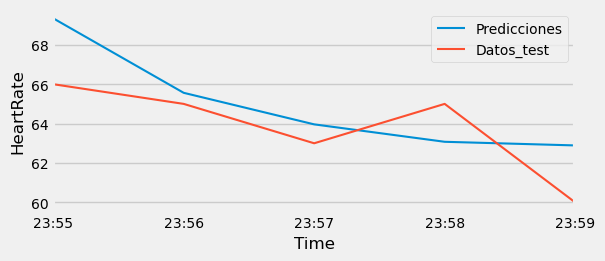

In [29]:
fig, ax = plt.subplots(figsize=(6, 2.5))


predicciones.plot(ax=ax, label='Predicciones')
datos_test['HeartRate'].plot(ax=ax, label='Datos_test')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()

# XGBoost

In [40]:
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = lags
             )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Differentiation order: None 
Exogen

In [41]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])
predicciones

2024-04-30 23:55:00    69.224411
2024-04-30 23:56:00    65.713776
2024-04-30 23:57:00    63.907448
2024-04-30 23:58:00    63.162544
2024-04-30 23:59:00    63.014301
Freq: 60s, Name: pred, dtype: float64

In [42]:
datos_test

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-04-30 23:55:00,BSGSML,1.57248,0.0,0.0,66.0
2024-04-30 23:56:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:57:00,BSGSML,1.31040,0.0,0.0,63.0
2024-04-30 23:58:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:59:00,BSGSML,1.31040,0.0,0.0,60.0


In [43]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 4.838403903742437


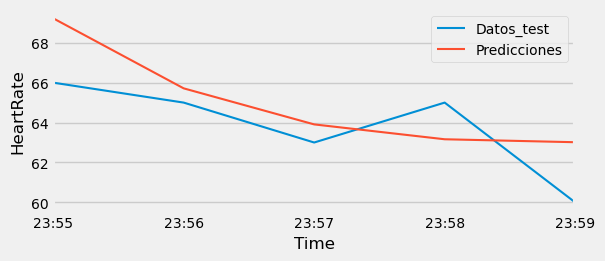

In [44]:
fig, ax = plt.subplots(figsize=(6, 2.5))


datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()

# Tunning XGBoost

In [46]:
lags_grid = [1, 20]

param_grid = {'n_estimators': [100,200, 500],
               'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                         forecaster         = forecaster,
                         y                  = datos_train['HeartRate'],
                         param_grid         = param_grid,
                         lags_grid          = lags_grid,
                         steps              = steps,
                         refit              = False,
                         metric             = 'mean_squared_error',
                         initial_train_size = int(len(datos_train)*0.5),
                         fixed_train_size   = False,
                         return_best        = True,
                         n_jobs             = 'auto',
                         verbose            = False
                   )

resultados_grid.head()
best_params = {'n_estimators': resultados_grid.iloc[0]['n_estimators'],
               'max_depth': resultados_grid.iloc[0]['max_depth']}

tunned_XGBoost_model = XGBRegressor(random_state=123, **best_params)
forecaster = ForecasterAutoreg(
                 regressor = tunned_XGBoost_model,
                 lags      = len(resultados_grid.iloc[0]['lags']),
                
              )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])

Number of models compared: 18.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 39.92395972258101



In [47]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])
predicciones

2024-04-30 23:55:00    69.852966
2024-04-30 23:56:00    64.405212
2024-04-30 23:57:00    62.884987
2024-04-30 23:58:00    61.715897
2024-04-30 23:59:00    61.077805
Freq: 60s, Name: pred, dtype: float64

In [48]:
datos_test

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-04-30 23:55:00,BSGSML,1.57248,0.0,0.0,66.0
2024-04-30 23:56:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:57:00,BSGSML,1.31040,0.0,0.0,63.0
2024-04-30 23:58:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:59:00,BSGSML,1.31040,0.0,0.0,60.0


In [50]:
# # Error test
# # ==============================================================================
error_mse = mean_squared_error(
                 y_true = datos_test['HeartRate'],
                 y_pred = predicciones
             )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 5.431869492132682


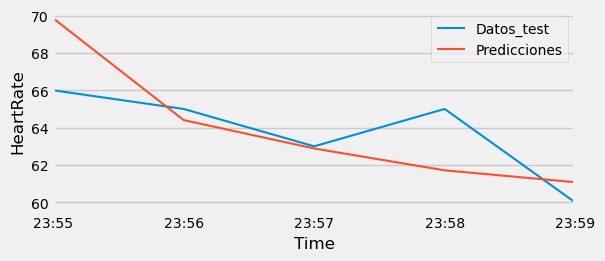

In [51]:
fig, ax = plt.subplots(figsize=(6, 2.5))

datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')
plt.show()

# KNN Regressor

In [52]:
n_neighbors = 5
knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

In [53]:
forecaster = ForecasterAutoreg(
                regressor = knn_model,
                lags      = lags
             )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])
forecaster

C:\Users\34634\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\34634\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


ForecasterAutoreg 
Regressor: KNeighborsRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Calories', 'Steps', 'Distance'] 
Training range: [Timestamp('2024-02-15 18:13:00'), Timestamp('2024-04-30 23:54:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60s 
Regressor parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} 
fit_kwargs: {} 
Creation date: 2024-05-21 19:05:16 
Last fit date: 2024-05-21 19:05:16 
Skforecast version: 0.11.0 
Python version: 3.9.13 
Forecaster id: None 

In [54]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])
predicciones

2024-04-30 23:55:00    70.8
2024-04-30 23:56:00    70.4
2024-04-30 23:57:00    71.8
2024-04-30 23:58:00    70.8
2024-04-30 23:59:00    68.6
Freq: 60s, Name: pred, dtype: float64

In [55]:
datos_test

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-04-30 23:55:00,BSGSML,1.57248,0.0,0.0,66.0
2024-04-30 23:56:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:57:00,BSGSML,1.31040,0.0,0.0,63.0
2024-04-30 23:58:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:59:00,BSGSML,1.31040,0.0,0.0,60.0


In [56]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 47.447999999999965


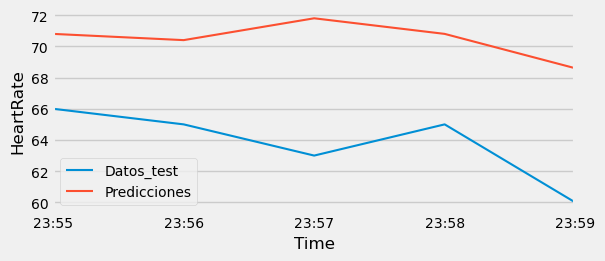

In [57]:
fig, ax = plt.subplots(figsize=(6, 2.5))


datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()

# Random Forest Regressor

In [58]:
n_estimators = 100 
max_depth = None 

random_forest_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=123)

In [59]:
forecaster = ForecasterAutoreg(
                regressor = random_forest_model,
                lags      = lags
             )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])
forecaster

C:\Users\34634\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\34634\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Calories', 'Steps', 'Distance'] 
Training range: [Timestamp('2024-02-15 18:13:00'), Timestamp('2024-04-30 23:54:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60s 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fi

In [60]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])
predicciones

2024-04-30 23:55:00    69.25
2024-04-30 23:56:00    66.60
2024-04-30 23:57:00    65.77
2024-04-30 23:58:00    64.69
2024-04-30 23:59:00    64.09
Freq: 60s, Name: pred, dtype: float64

In [61]:
datos_test

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-04-30 23:55:00,BSGSML,1.57248,0.0,0.0,66.0
2024-04-30 23:56:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:57:00,BSGSML,1.31040,0.0,0.0,63.0
2024-04-30 23:58:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:59:00,BSGSML,1.31040,0.0,0.0,60.0


In [62]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 7.523919999999997


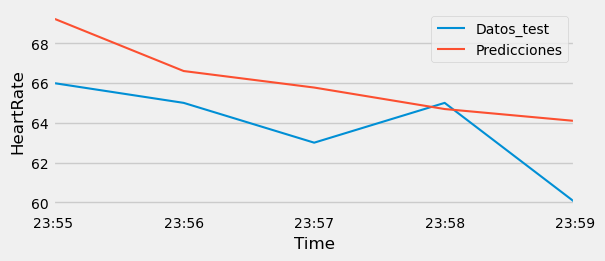

In [63]:
fig, ax = plt.subplots(figsize=(6, 2.5))


datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()

# MLP Regressor

In [64]:
MLP_model = MLPRegressor(random_state=123, max_iter=2000)

In [65]:
forecaster = ForecasterAutoreg(
                regressor = MLP_model,
                lags      = lags
             )

forecaster.fit(y=datos_train['HeartRate'], exog=datos_train[['Calories','Steps','Distance']])
forecaster

C:\Users\34634\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\34634\anaconda3\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


ForecasterAutoreg 
Regressor: MLPRegressor(max_iter=2000, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Calories', 'Steps', 'Distance'] 
Training range: [Timestamp('2024-02-15 18:13:00'), Timestamp('2024-04-30 23:54:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60s 
Regressor parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 123, 'shuffle'

In [66]:
predicciones = forecaster.predict(steps=steps,  exog=datos_test[['Calories', 'Steps', 'Distance']])
predicciones

2024-04-30 23:55:00    67.740671
2024-04-30 23:56:00    64.149869
2024-04-30 23:57:00    62.112436
2024-04-30 23:58:00    60.338409
2024-04-30 23:59:00    58.857160
Freq: 60s, Name: pred, dtype: float64

In [67]:
datos_test

,Id,Calories,Distance,Steps,HeartRate
Time,,,,,
2024-04-30 23:55:00,BSGSML,1.57248,0.0,0.0,66.0
2024-04-30 23:56:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:57:00,BSGSML,1.31040,0.0,0.0,63.0
2024-04-30 23:58:00,BSGSML,1.31040,0.0,0.0,65.0
2024-04-30 23:59:00,BSGSML,1.31040,0.0,0.0,60.0


In [68]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['HeartRate'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 5.515388618485106


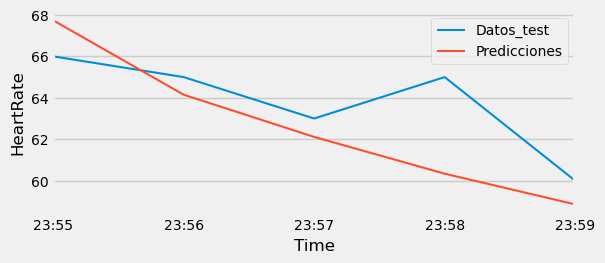

In [69]:
fig, ax = plt.subplots(figsize=(6, 2.5))

datos_test['HeartRate'].plot(ax=ax, label='Datos_test')
predicciones.plot(ax=ax, label='Predicciones')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('HeartRate')

plt.show()